In [131]:
# Essential tools for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# KMeans tools
from sklearn.cluster import KMeans
import prince
from yellowbrick.cluster import KElbowVisualizer
# Hierarchical Clustering tools
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# Setting current working directory
import os
os.chdir(r'C:\Users\QQ\Documents\Learning\The Data Science Course')

In [132]:
data = pd.read_csv('train-set.csv')
df = data.copy()

In [133]:
df.head()

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6,A


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      8068 non-null   int64  
 1   Gender          8068 non-null   object 
 2   Married         7928 non-null   object 
 3   Age             8068 non-null   int64  
 4   Graduated       7990 non-null   object 
 5   Profession      7944 non-null   object 
 6   WorkExperience  7239 non-null   float64
 7   SpendingScore   8068 non-null   object 
 8   FamilySize      7733 non-null   float64
 9   Category        7992 non-null   object 
 10  Segmentation    8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [135]:
# Dropping redundant variables
df.dropna(inplace= True)
df.drop(['CustomerID', 'Segmentation'], axis =1, inplace = True)

### Univariate Visualization

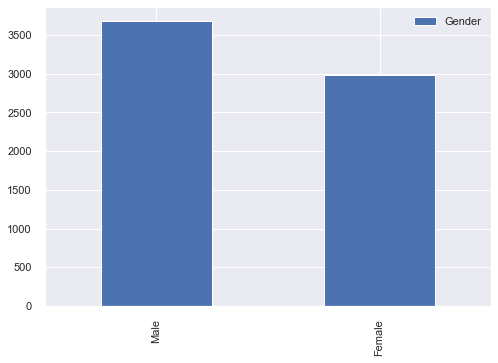

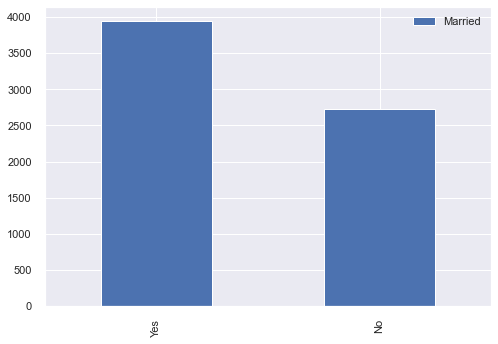

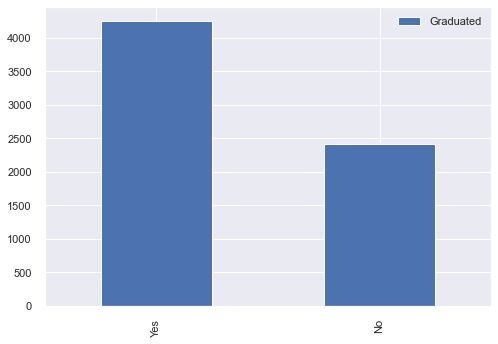

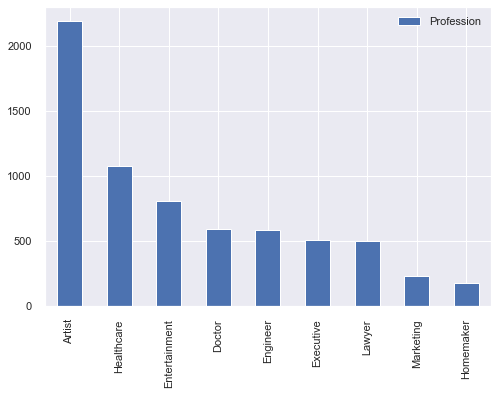

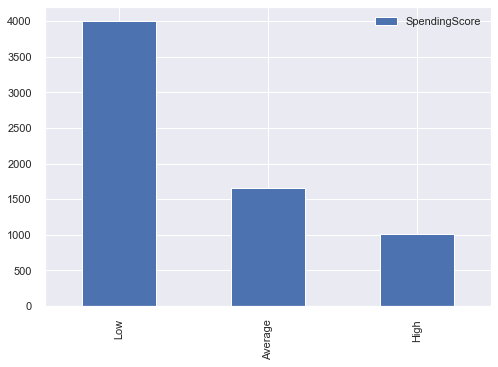

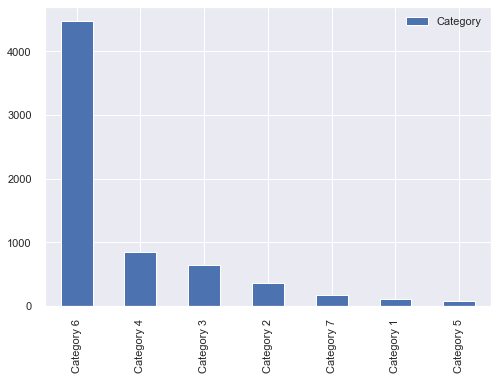

In [136]:
# Categorical Variables
categorical_vars = ['Gender', 'Married', 'Graduated', 'Profession','SpendingScore', 'Category']

for var in categorical_vars:
    feature_df = pd.DataFrame(df[var].value_counts())
    feature_df.plot(kind = 'bar')

In [137]:
# Continuous variables
cont_vars = []
for var in df.columns:
    i = var in categorical_vars
    if i==False:
        cont_vars.append(var)

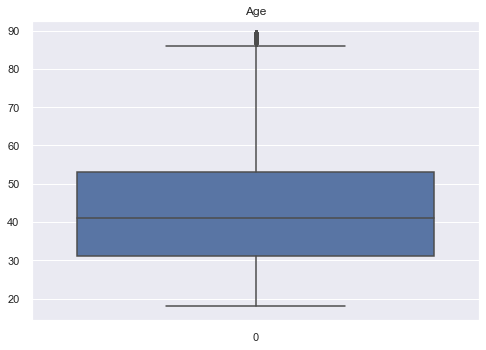

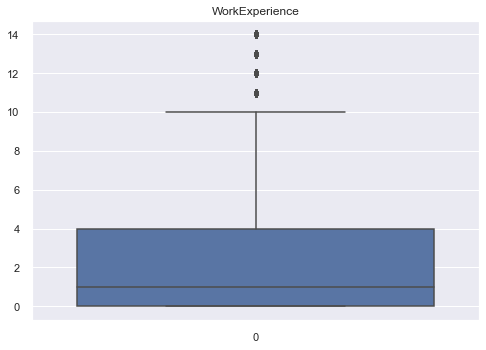

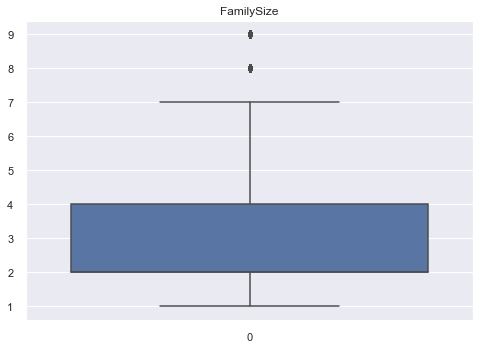

<Figure size 576x396 with 0 Axes>

In [138]:
for var in cont_vars:
    sns.boxplot(data = df[var]).set_title(var)
    plt.figure()

### FAMD

In [139]:
# Factor Analysis of Mixed Data
famd = prince.FAMD(n_components = 10,
                  copy = True,
                  check_input = True,
                  engine = 'auto',
                  random_state = 42)

In [140]:
# Fitting famd to dataset
famd_mod = famd.fit_transform(df)

In [141]:
# Total explained variance by principal components used
sum(famd_mod.explained_inertia_)

0.6777431646864748

In [142]:
# Creating dataframe with row coordinates from famd
df_famd = pd.DataFrame(famd_mod.row_coordinates(df))

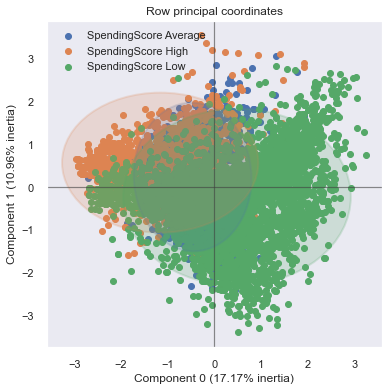

In [143]:
# Row coordinates plot for implemented famd
axes = famd.plot_row_coordinates(df,
                                x_component = 0,
                                y_component = 1,
                                color_labels =['SpendingScore {}'.format(t) for t in df['SpendingScore']],
                                ellipse_outline = True,
                                ellipse_fill = True,
                                show_points = True)

### K-Means

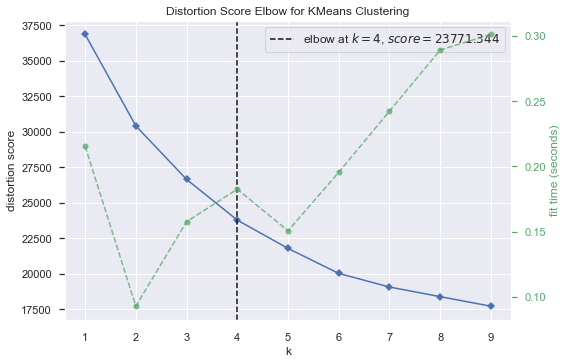

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [144]:
# Selecting optimal number of clusters for KMeans cluster
model = KMeans()
visualizer = KElbowVisualizer(model, k =(1,10), timings = True)
visualizer.fit(df_famd)
visualizer.show()

In [145]:
# Running KMeans with 4 clusters
kmeans = KMeans(4)
kmeans.fit(df_famd)
df_famd['cluster'] = kmeans.predict(df_famd)

In [146]:
df_famd.head()

,0,1,2,3,4,5,6,7,8,9,cluster
0,1.940110,0.893212,-0.508875,0.491225,-0.278233,0.384167,-0.067760,-0.538627,-0.055706,-0.380606,3
2,-1.438046,-0.499340,-0.801842,0.058087,1.110046,0.299500,-0.570997,-0.355138,0.076962,-0.336689,2
3,-2.172402,0.540685,-0.234951,1.055131,-0.223370,-0.492816,0.337276,-0.082092,-0.144237,0.060605,1
5,-1.053801,0.437347,-0.130205,-0.528282,-0.382237,0.512604,-0.177805,-0.398886,0.318378,0.102313,2
6,0.910450,0.115195,-0.761372,0.010425,-0.776508,-0.728782,-0.036775,-0.279839,0.186591,-0.192864,3


Text(0.5, 1.0, 'Customer Clusters segmented by first two Principal Components')

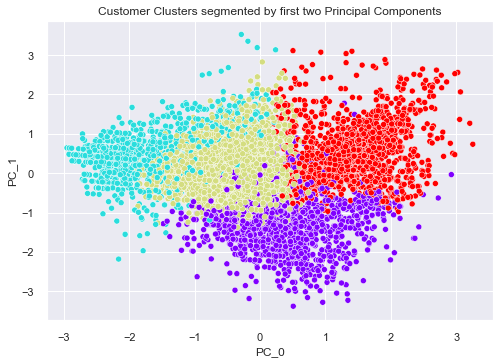

In [147]:
sns.scatterplot(x = df_famd[0], y = df_famd[1], c = df_famd['cluster'],cmap = 'rainbow')
plt.xlabel('PC_0')
plt.ylabel('PC_1')
plt.title('Customer Clusters on axes of first two Principal Components - KMeans')

In [148]:
kmeans_df = df.join(df_famd['cluster'], how = 'left')

In [149]:
kmeans_df.head()

,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,cluster
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4,3
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6,2
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6,1
5,Male,Yes,56,No,Artist,0.0,Average,2.0,Category 6,2
6,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Category 6,3


###  Basic EDA on Dataframe of Original Features with new Clusters - KMeans

Text(0.5, 1.0, 'Cluster Distribution of Customer - KMeans')

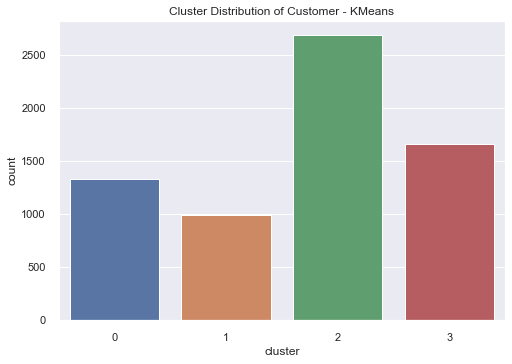

In [150]:
sns.countplot(x = kmeans_df['cluster'])
plt.title('Cluster Distribution of Customer - KMeans')

In [151]:
k_exp_df = kmeans_df.copy()
k_exp_df.drop('cluster', axis = 1, inplace = True)
k_cat_vars = [var for var in k_exp_df.columns if k_exp_df[var].dtype == 'object']
k_cont_vars = [var for var in k_exp_df.columns if k_exp_df[var]. dtype != 'object']

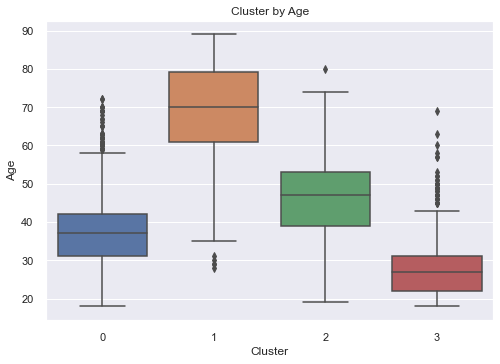

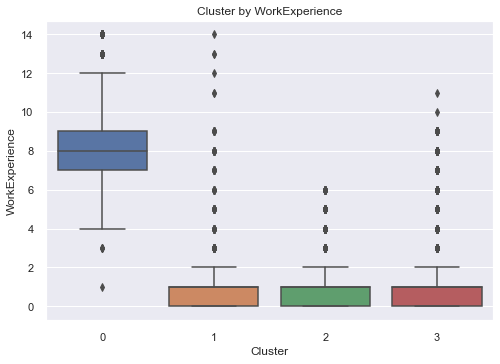

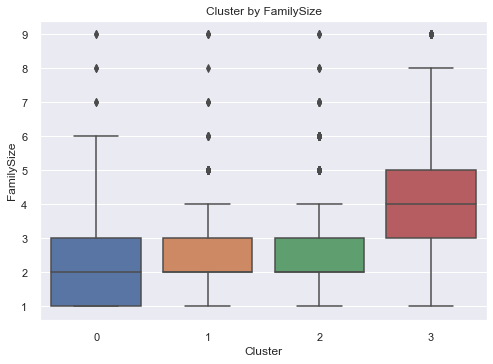

In [152]:
for cont_var in k_cont_vars:
    plt.figure()
    sns.boxplot(x = kmeans_df['cluster'], y = kmeans_df[cont_var])
    plt.xlabel('Cluster')
    plt.ylabel(cont_var)
    plt.title('Cluster by ' + cont_var)

<Figure size 576x396 with 0 Axes>

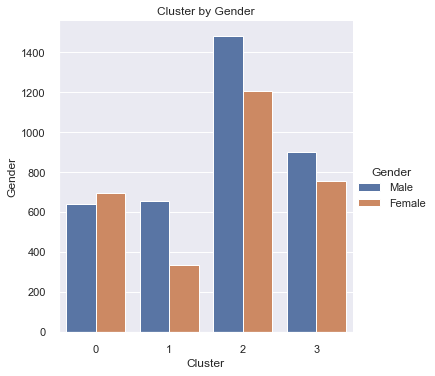

<Figure size 576x396 with 0 Axes>

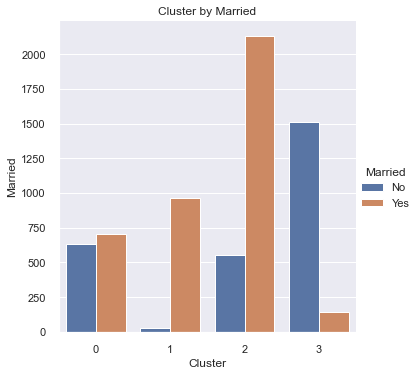

<Figure size 576x396 with 0 Axes>

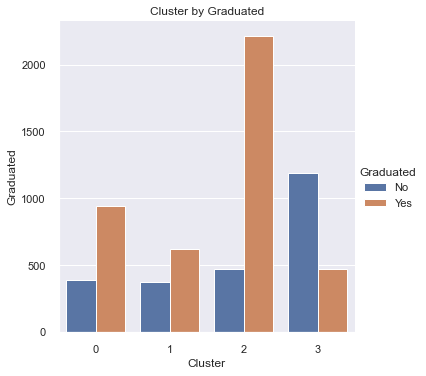

<Figure size 576x396 with 0 Axes>

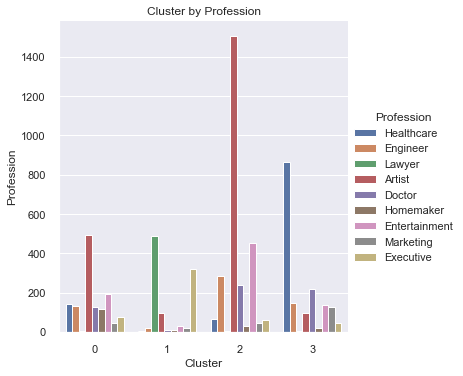

<Figure size 576x396 with 0 Axes>

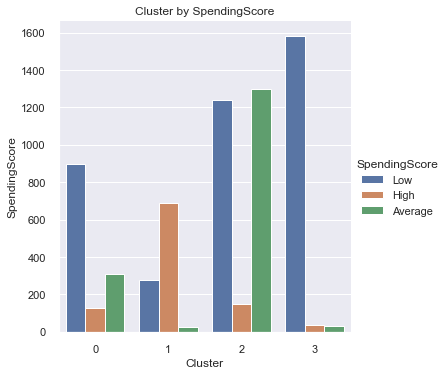

<Figure size 576x396 with 0 Axes>

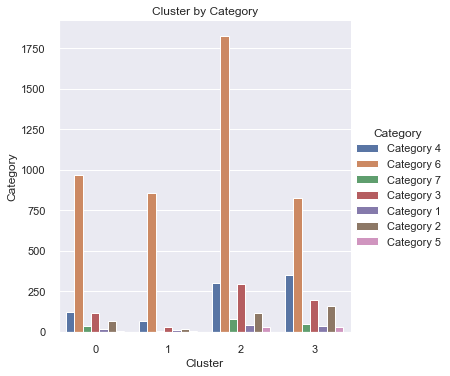

In [153]:
for cat_var in k_cat_vars:
    plt.figure()
    sns.catplot(x = 'cluster', hue = cat_var, data = kmeans_df, kind = 'count' )
    plt.xlabel('Cluster')
    plt.ylabel(cat_var)
    plt.title('Cluster by ' + cat_var)

In [154]:
df_hc = df_famd.copy()
df_hc.drop('cluster', axis =1, inplace = True)
df_hc.head()

,0,1,2,3,4,5,6,7,8,9
0,1.940110,0.893212,-0.508875,0.491225,-0.278233,0.384167,-0.067760,-0.538627,-0.055706,-0.380606
2,-1.438046,-0.499340,-0.801842,0.058087,1.110046,0.299500,-0.570997,-0.355138,0.076962,-0.336689
3,-2.172402,0.540685,-0.234951,1.055131,-0.223370,-0.492816,0.337276,-0.082092,-0.144237,0.060605
5,-1.053801,0.437347,-0.130205,-0.528282,-0.382237,0.512604,-0.177805,-0.398886,0.318378,0.102313
6,0.910450,0.115195,-0.761372,0.010425,-0.776508,-0.728782,-0.036775,-0.279839,0.186591,-0.192864


### Hierarchical Clustering

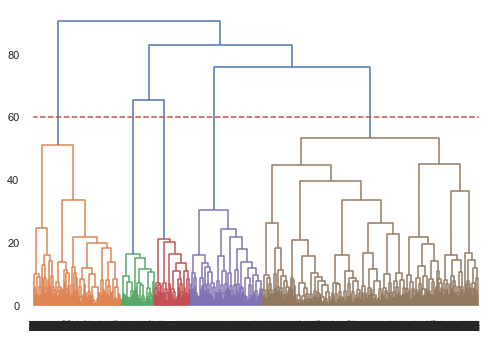

In [155]:
# Dendrogram for Hierarchical CLustering with 60 selected as cutoff point
dend = shc.dendrogram(shc.linkage(df_hc, method = 'ward'))
plt.axhline(y=60, color='r', linestyle='--')
# 5 clusters visible

In [156]:
cluster = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
df_hc['cluster'] = cluster.fit_predict(df_hc)

Text(0.5, 1.0, 'Customer Clusters segmented by first two Principal Components')

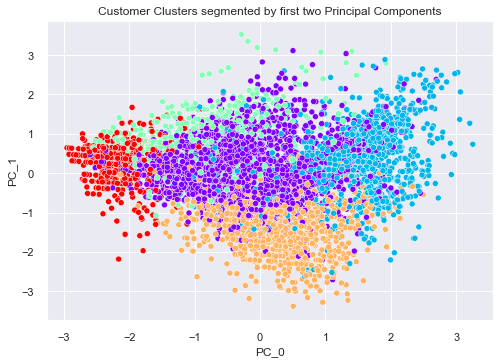

In [157]:
sns.scatterplot(x=df_hc[0], y=df_hc[1], c= df_hc['cluster'], cmap = 'rainbow')
plt.xlabel('PC_0')
plt.ylabel('PC_1')
plt.title('Customer Clusters segmented by first two Principal Components')
# Segmentation not as clear cut as KMeans

###  Basic EDA on Dataframe of Original Features with new Clusters - Hierarchical Clustering

In [158]:
hcs_df = df.join(df_hc['cluster'], how = 'left')

Text(0.5, 1.0, 'Cluster Distribution of Customer - Hierarchichal Clustering')

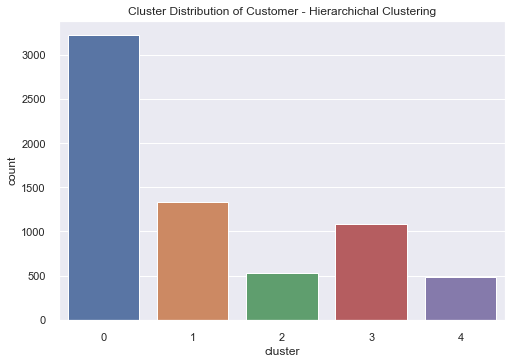

In [159]:
hcs_df['cluster'].value_counts()
sns.countplot(x=hcs_df['cluster'])
plt.title('Cluster Distribution of Customer - Hierarchichal Clustering')

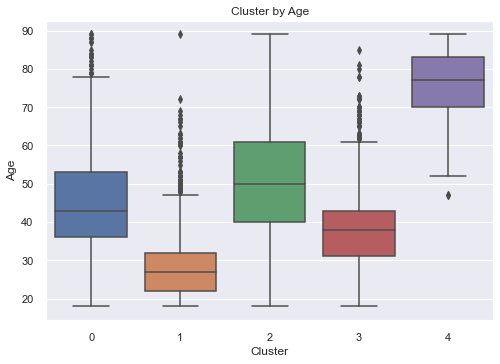

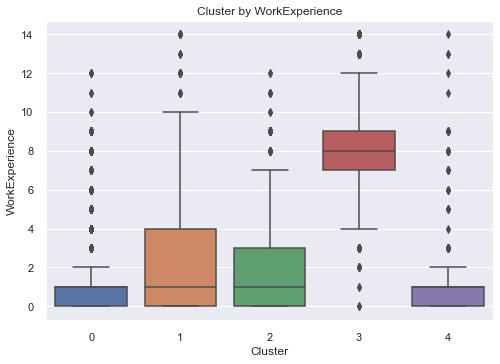

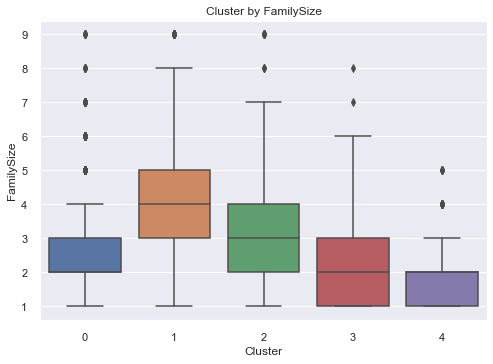

In [160]:
for cont_var in k_cont_vars:
    plt.figure()
    sns.boxplot(x = hcs_df['cluster'], y = hcs_df[cont_var])
    plt.xlabel('Cluster')
    plt.ylabel(cont_var)
    plt.title('Cluster by ' + cont_var)

<Figure size 576x396 with 0 Axes>

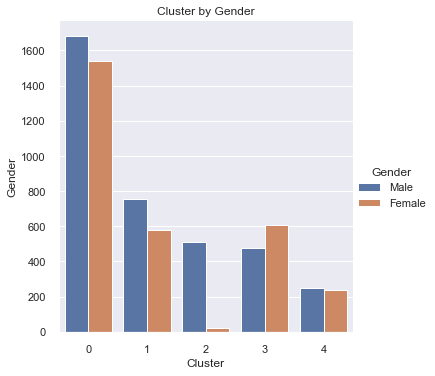

<Figure size 576x396 with 0 Axes>

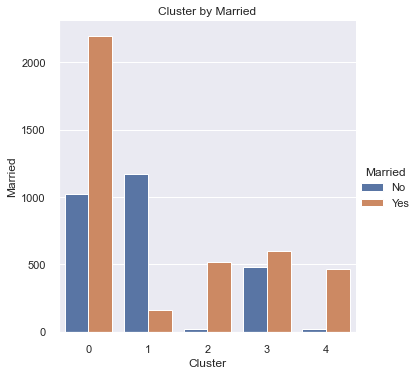

<Figure size 576x396 with 0 Axes>

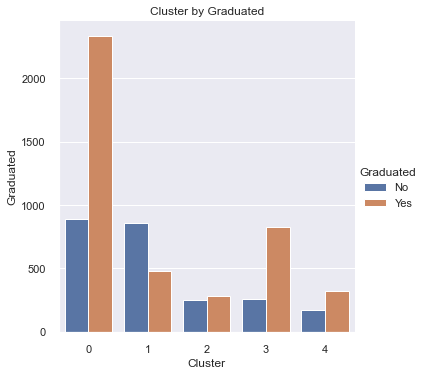

<Figure size 576x396 with 0 Axes>

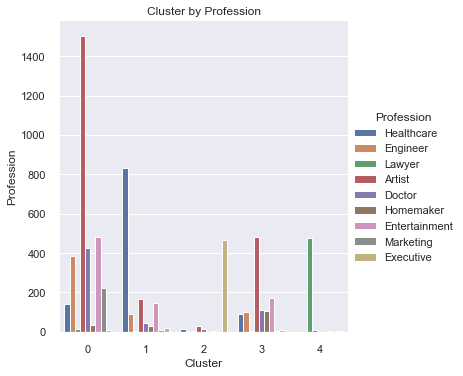

<Figure size 576x396 with 0 Axes>

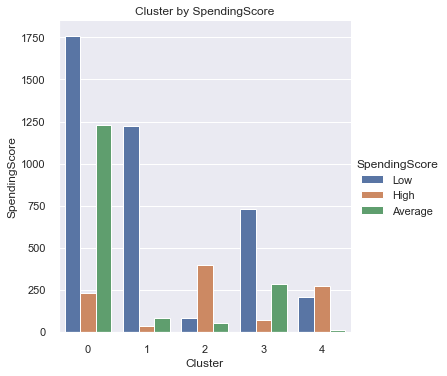

<Figure size 576x396 with 0 Axes>

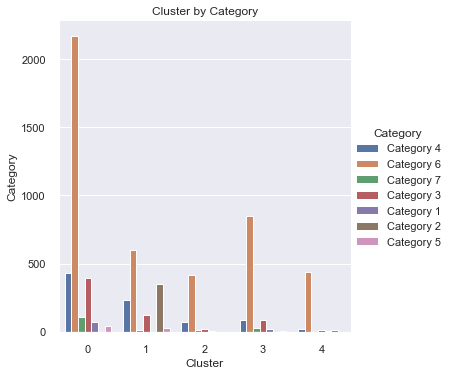

In [161]:
for cat_var in k_cat_vars:
    plt.figure()
    sns.catplot(x = 'cluster', hue = cat_var, data = hcs_df, kind = 'count' )
    plt.xlabel('Cluster')
    plt.ylabel(cat_var)
    plt.title('Cluster by ' + cat_var)